# 0.0. IMPORTS

In [1]:
import numpy  as np
import pandas as pd
import inflection
import datetime

import seaborn as sns


from matplotlib           import pyplot as plt
from IPython.display      import Image
from matplotlib.gridspec  import GridSpec
from IPython.core.display import HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [3]:
jupyter_settings()

## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

#merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

In [6]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
cols_old = df1.columns
print("Old cols: "+str( cols_old ) )

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )
print("\nSnakecase cols: "+str( cols_new) )

# rename
df1.columns = cols_new

Old cols: Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

Snakecase cols: ['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval']


## 1.2. Data Dimensions

In [8]:
print('Number of rows: {}'.format( df1.shape[0] ) )
print('Number of cols: {}'.format( df1.shape[1] ) )

Number of rows: 1017209
Number of cols: 18


## 1.3. Data Types

In [9]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
#competition_distance       
max_competition_distance = df1.competition_distance.max()
new_max_competition_distance = max_competition_distance*3
df1.loc[df1.competition_distance.isna(), 'competition_distance'] = new_max_competition_distance

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1)


#promo2_since_week         
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1)


#promo2_since_year      
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1)


#promo_interval              
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [12]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [13]:
#promo2 change float64 to int64
df1['promo2_since_week']            = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year']            = df1['promo2_since_year'].astype('int64')  

#competition change float64 to int64
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype('int64')
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Atributes

In [15]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


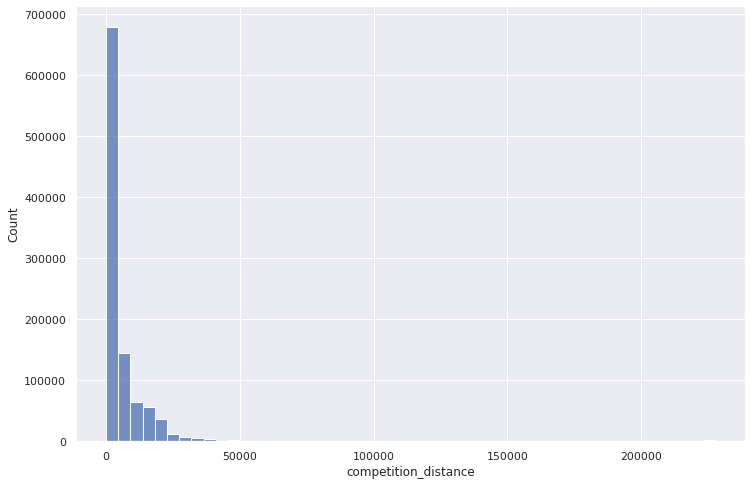

In [16]:
plt.figure(figsize=(12,8))
sns.histplot( df1['competition_distance'], bins=50, kde=False );

### 1.7.2 Categorical Atributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

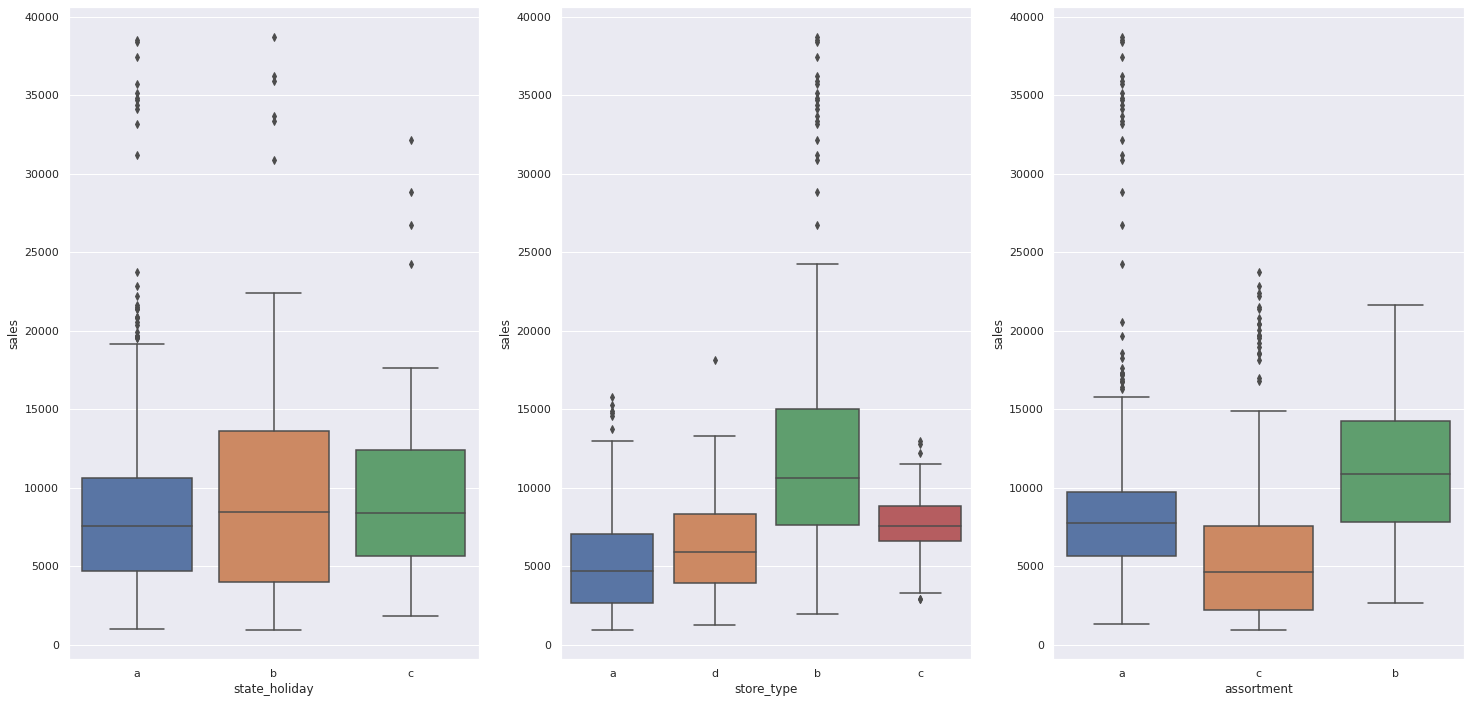

In [18]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux );

# 2.0. HYPOTHESES

## 2.1. Hypotheses Mind Map

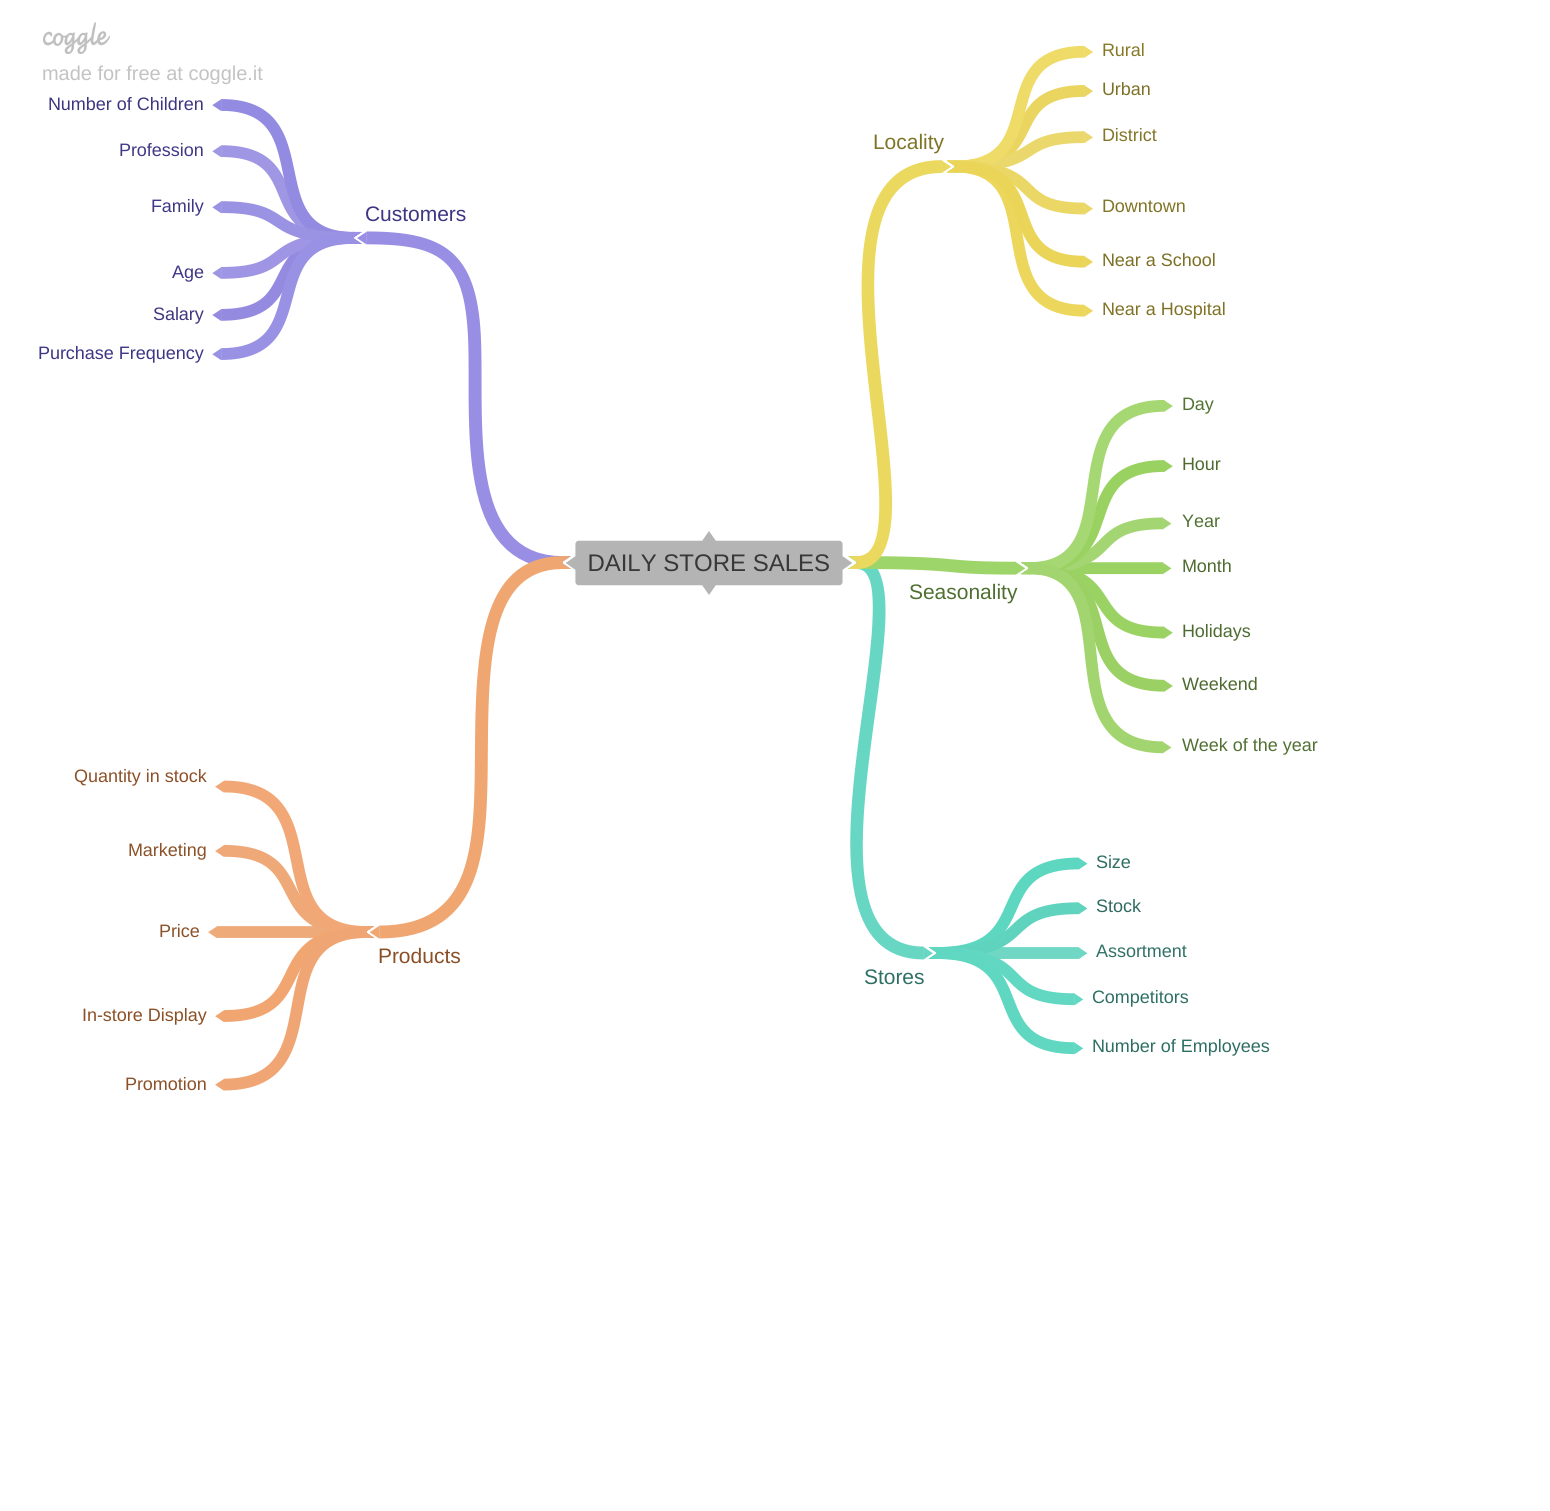

In [19]:
Image( 'img/mind-map-hypotheses.png')

## 2.2. Hypotheses Criation

### 2.2.1. Store Hypotheses



**1.** Stores with a larger number of employees should sell more.

**2.** Stores with greater stock capacity should sell more.

**3.** Larger stores should sell more than smaller ones.

**4.** Stores with more assortment should sell more.

**5.** Stores with competitors equal to or less than 4Km away shold sell less.

**6.** Stores with longer competitors should sell more.

**7.** Stores with competitors more than 10KM away should have higher sales averages.

### 2.2.2. Product Hypotheses

**1.** Stores that invest more in marketing should sell more.

**2.** Stores that display more products in their windows should sell more.

**3.** Stores with cheaper products should sell more.

**4.** Stores with more aggressive promotions (bigger discounts) should sell more.

**5.** Stores with longer promotions should sell more.

**6.** Stores with more days of promotion should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 2.2.3. Seasonality Hypotheses

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

**7.** Stores sell less in summer.

## 2.3. Final List of Hypotheses

**1.** Stores with more assortment should sell more.

**2.** SStores with competitors equal to or less than 4Km away shold sell less.

**3.** Stores with longer competitors should sell more.

**4.** Stores with competitors more than 10KM away should have higher sales averages.

**5.** Stores with longer promotions should sell more.

**6.** Stores with more days of promotion should sell more.

**7.** Stores with more consecutive promotions should sell more.

**8.** Stores open during the Christmas holiday should sell more.

**9.** Stores should sell more over the years.

**10.** Stores should sell more in the second half of the year.

**11.** Stores should sell more after the 10th of each month.

**12.** Stores should sell less on weekends.

**13.** Stores should sell less during school holidays.

**14.** Stores sell less in summer.

# 3.0. FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

In [21]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

#year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

#promo since
df2['promo_since']     = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since']     = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

#assortment
df2['assortment']      = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended' )

#state holiday
df2['state_holiday']   = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [22]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 4.0. VARIABLE FILTERING

In [23]:
df3 = df2.copy()

### 4.1. Line Filtering

In [24]:
df3 = df3[ ( df3['open'] != 0 ) & ( df3['sales'] > 0 ) ]
df3.shape

(844338, 29)

### 4.2. Column Selection

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1)

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 5.0. EXPLORATORY DATA ANALYSIS

In [26]:
df4 = df3.copy()

## 5.1. Univariate Analysis

### 5.1.1. Response Variable

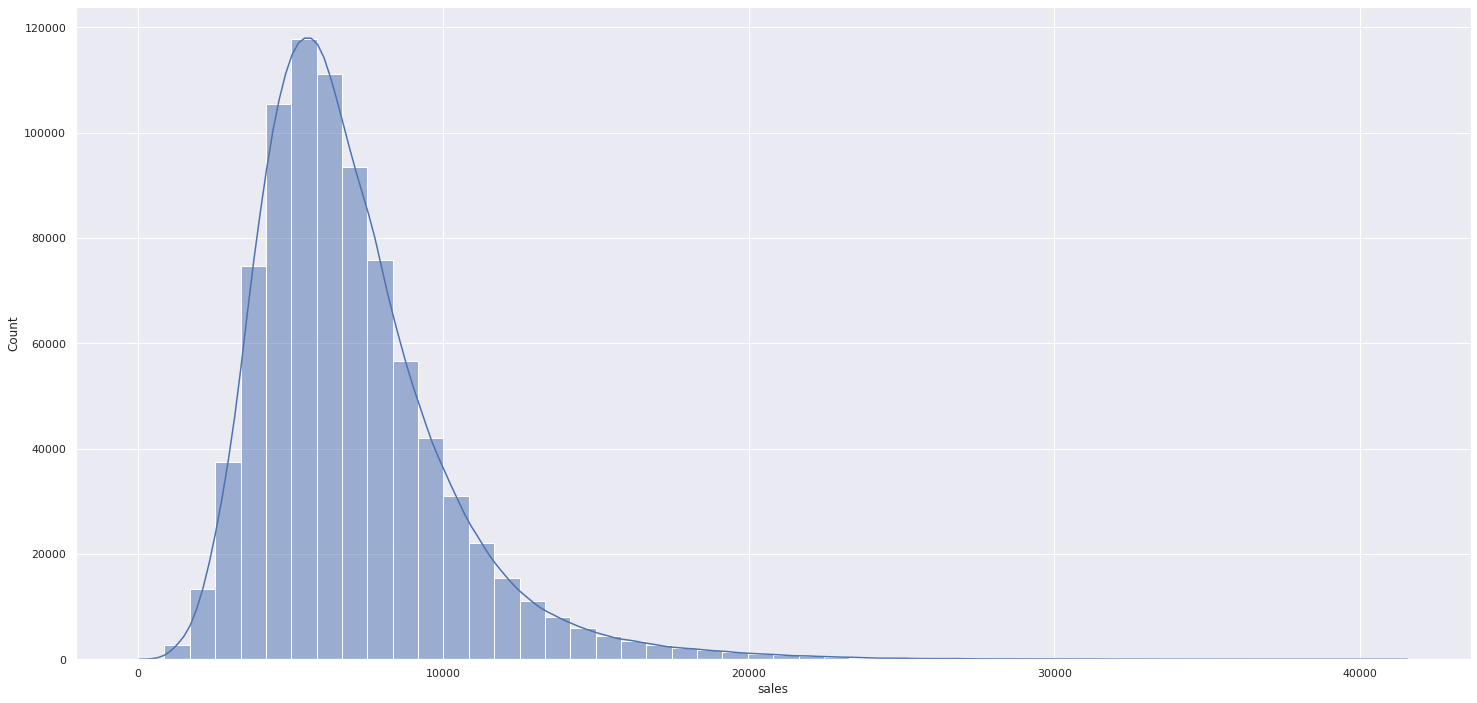

In [27]:
sns.histplot( df4['sales'], bins=50, kde=True);

### 5.1.2. Numerical Variable

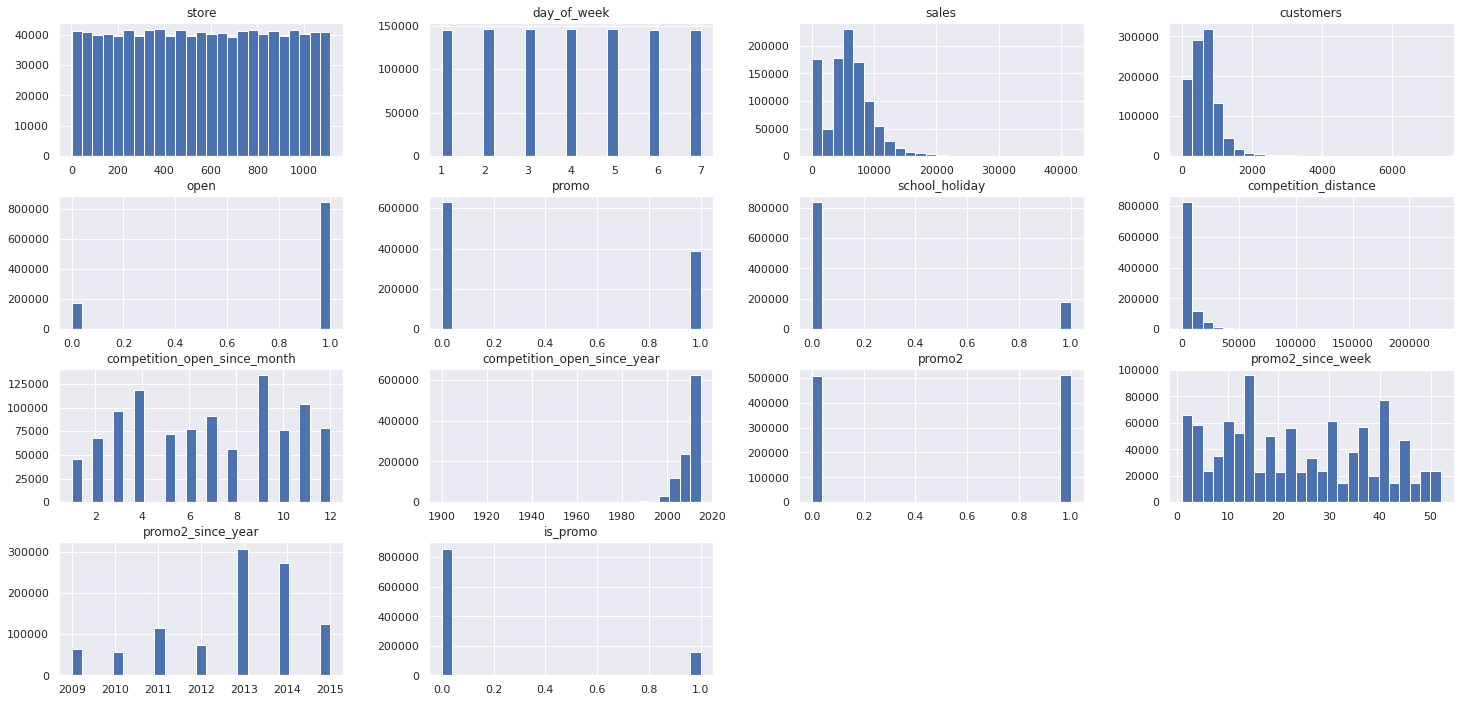

In [28]:
num_attributes.hist( bins=25 );

### 5.1.3. Categorical Variable

In [29]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [30]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [31]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

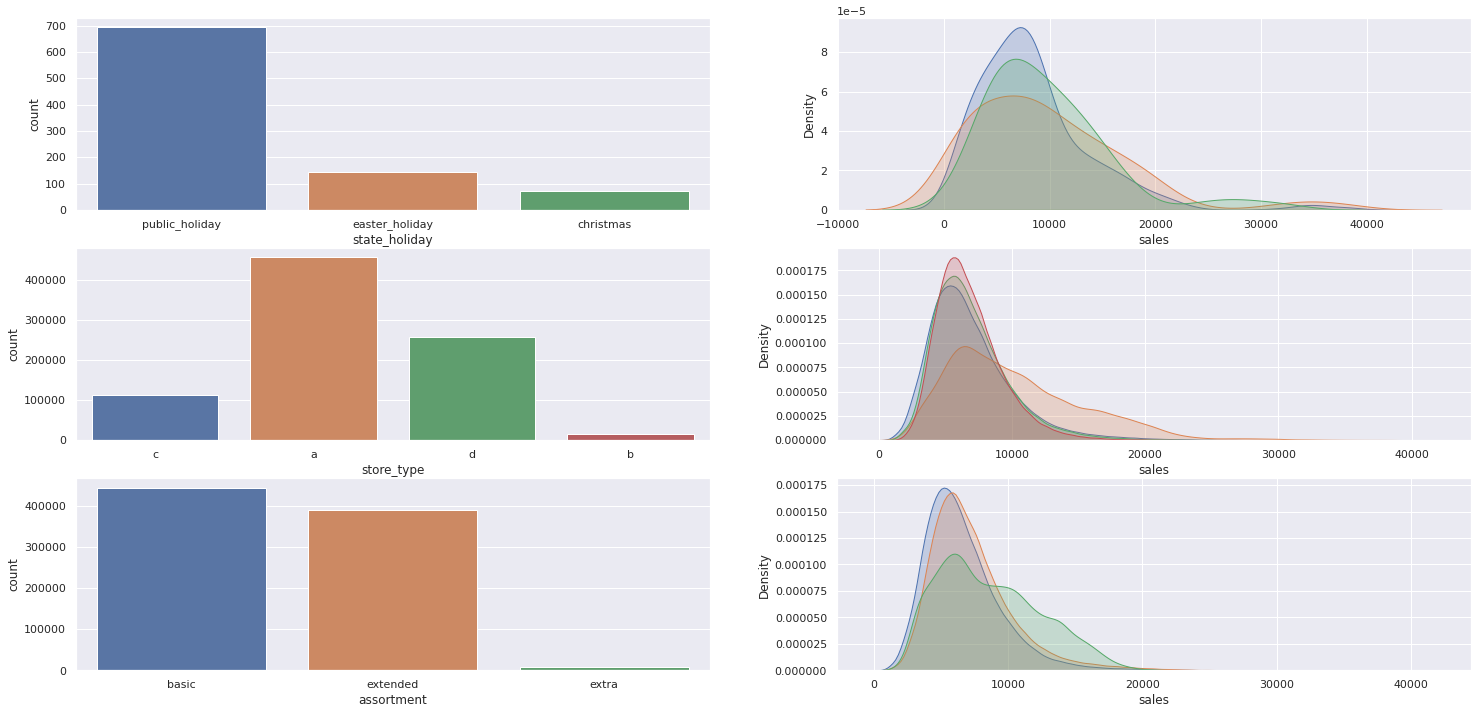

In [32]:
#state_holiday
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(3, 2, 1)
sns.countplot(x='state_holiday', data=aux)

plt.subplot(3, 2, 2)
sns.kdeplot( aux[ aux['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( aux[ aux['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( aux[ aux['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

#store_type
plt.subplot(3, 2, 3)
sns.countplot(x='store_type', data=df4)

plt.subplot(3, 2, 4)
sns.kdeplot( df4[ df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[ df4['store_type'] == 'd']['sales'], label='d', shade=True )

#assortment
plt.subplot(3, 2, 5)
sns.countplot(x='assortment', data=df4)

plt.subplot(3, 2, 6)
sns.kdeplot( df4[ df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[ df4['assortment'] == 'extra']['sales'], label='extra', shade=True )


plt.show()


## 5.2. Bivariate Analysis

In [33]:
df5 = df4.copy()

### **H1.** Stores with more assortment should sell more.

**Assumption:** Stores with 'extra' assortment is greater than 'basic' and 'extended'

#### **FALSE: Stores with more assortment sell less**

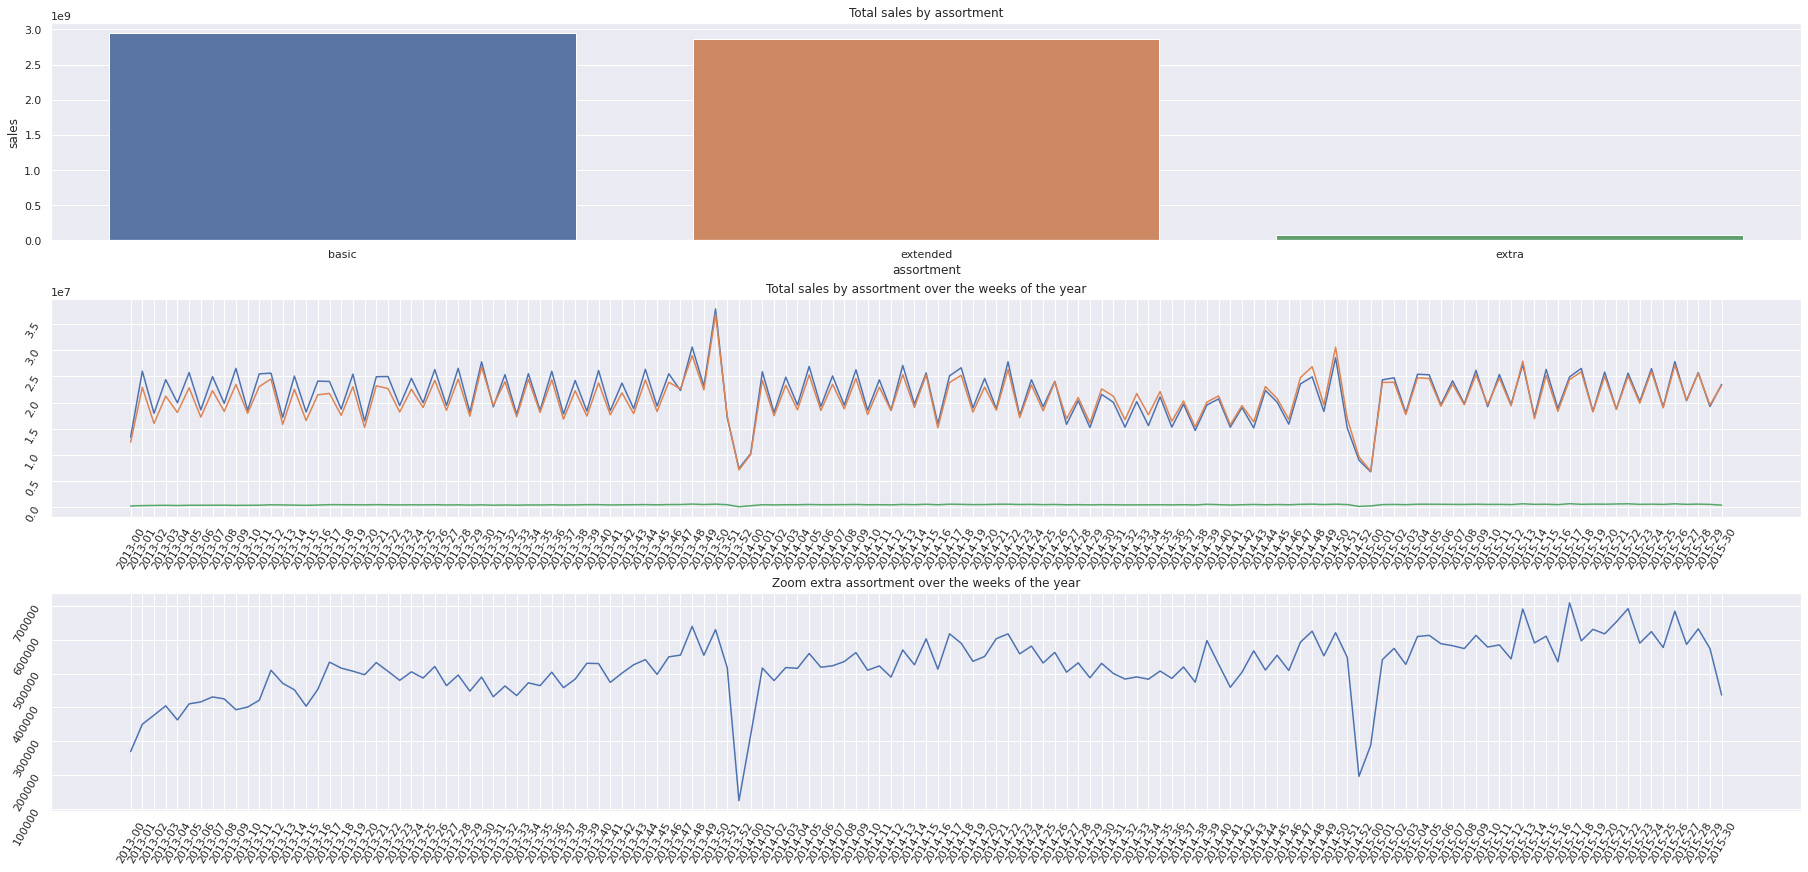

In [34]:
#Total sales by assortment
aux1 = df5[['assortment', 'sales']].groupby('assortment').sum().reset_index()

#Total sales by assortment over the weeks of the year
aux2 = df5[['year_week', 'assortment', 'sales']].groupby(['assortment', 'year_week']).sum().reset_index()
aux2_pivot = aux2.pivot( index='year_week', columns='assortment', values='sales')

#Total sales by extra assortment over the weeks of the year
aux3 = aux2[ aux2['assortment'] == 'extra']
aux3_pivot = aux3.pivot( index='year_week', columns='assortment', values='sales')


fig = plt.figure(constrained_layout=True)
specs = GridSpec(3, 1, figure=fig)

ax1 = fig.add_subplot(specs[0, 0])
ax1.set_title('Total sales by assortment')
sns.barplot(x='assortment', y='sales', ax=ax1, data=aux1)

ax2 = fig.add_subplot(specs[1, 0])
ax2.set_title('Total sales by assortment over the weeks of the year')
ax2.tick_params(labelrotation=60)
ax2.plot(aux2_pivot.index, aux2_pivot.values)

ax3 = fig.add_subplot(specs[2, 0])
ax3.set_title('Zoom extra assortment over the weeks of the year')
ax3.tick_params(labelrotation=60)
ax3.plot(aux3_pivot.index, aux3_pivot.values)



plt.show()


### **H2.** Stores with competitors equal to or less than 4Km away shold sell less.

#### FALSE: Stores with competitors at a distance equal to or less than 4 km sell around 72% of total sales.

Total sales for competitors up to 2km: 4284651086
Total sales for competitors greater than 2km: 1588529537
Percentage of sales in stores that are up to 2km away: 72.95%


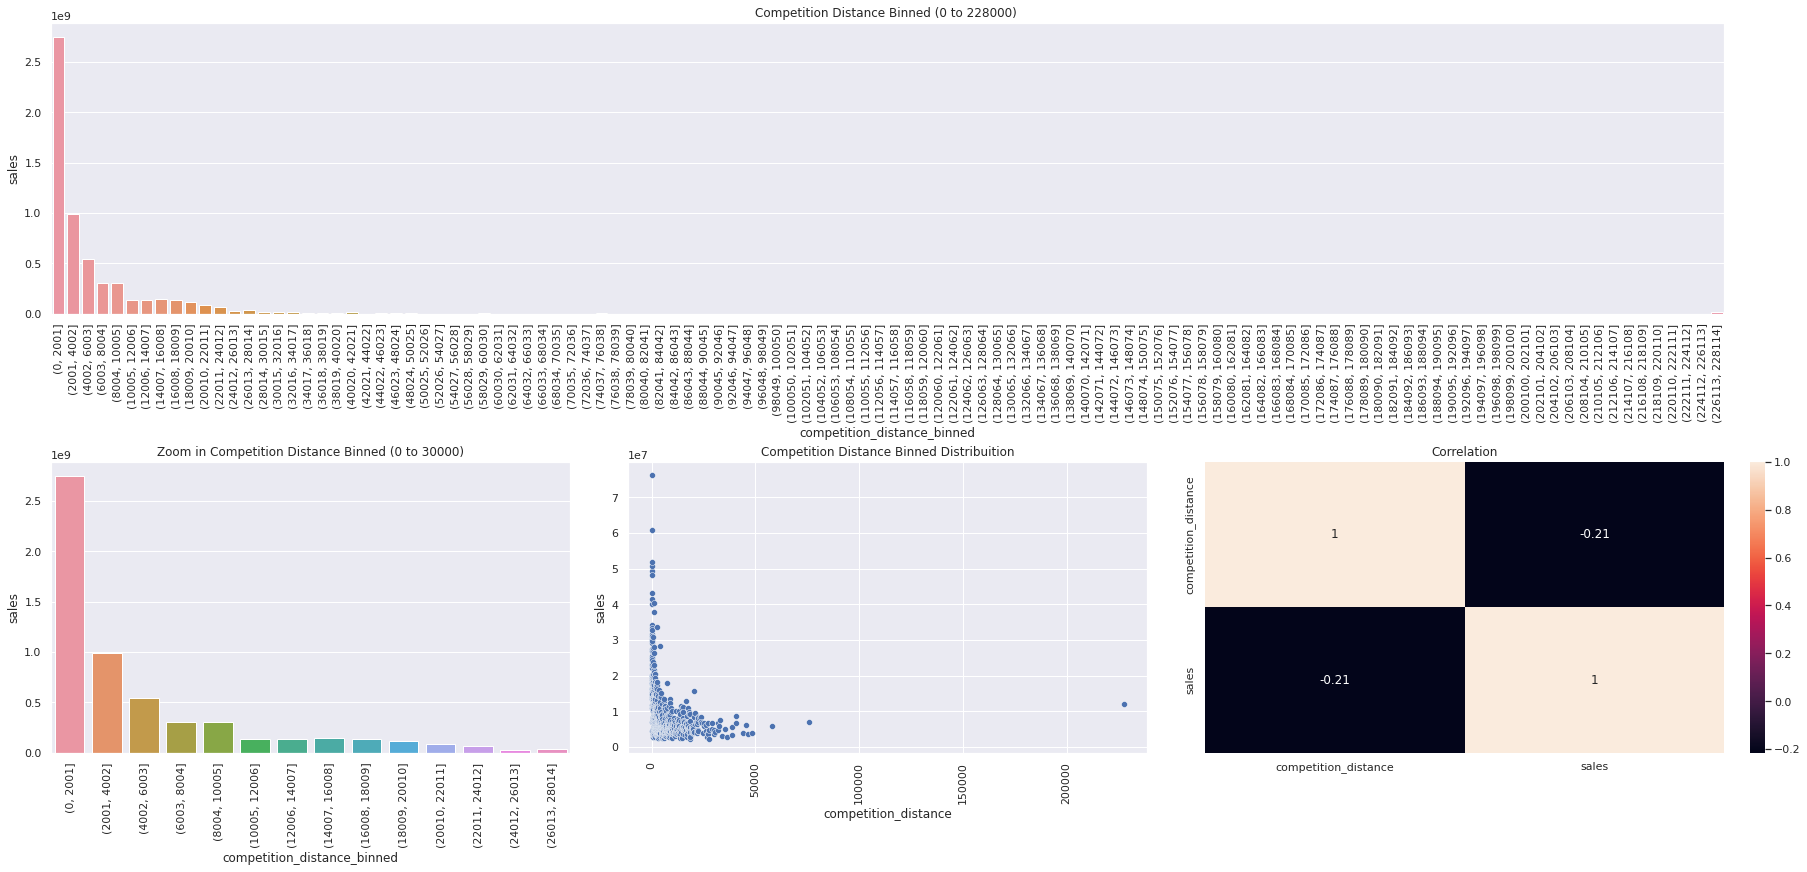

In [35]:
aux1 = df5[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
aux2 = aux1.copy()

bins1 = list(np.arange(0, 229000, 2001))
bins2 = list(np.arange(0,  30000, 2001))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins1)
aux2['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins2)

total_sales_4km = aux1.iloc[:,1][0:384].sum()
total_sales_greater_4km = aux1.iloc[:,1][384:].sum()

percent_total_sales_4km = (total_sales_4km * 100) / aux1['sales'].sum()
print('Total sales for competitors up to 2km: {}'.format(total_sales_4km))
print('Total sales for competitors greater than 2km: {}'.format(total_sales_greater_4km))
print('Percentage of sales in stores that are up to 2km away: {}%'.format(round(percent_total_sales_4km,2)))

aux3 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index() 
aux4 = aux2[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index() 

fig = plt.figure(constrained_layout=True)
specs = GridSpec(6, 3, figure=fig)


ax1 = fig.add_subplot(specs[0:3, 0:])
ax1.set_title('Competition Distance Binned (0 to 228000) ')
sns.barplot(x='competition_distance_binned', y='sales', ax=ax1, data=aux3)
plt.xticks(rotation=90);

ax2 = fig.add_subplot(specs[3:, 0])
ax2.set_title('Zoom in Competition Distance Binned (0 to 30000)')
sns.barplot(x='competition_distance_binned', y='sales', ax=ax2, data=aux4)
plt.xticks(rotation=90);

ax3 = fig.add_subplot(specs[3:, 1])
ax3.set_title('Competition Distance Binned Distribuition')
sns.scatterplot(x='competition_distance', y='sales', ax=ax3, data=aux1)
plt.xticks(rotation=90)

ax4 = fig.add_subplot(specs[3:, 2])
ax4.set_title('Correlation')
sns.heatmap(aux1.corr(method='pearson'), annot=True);

total_sales_2km = aux2.iloc[:,1][0]
total_sales_greater_2km = aux2.iloc[:,1][1:].sum()



### **H3.** Stores with longer competitors should sell more.

#### FALSE: Stores with longer competitors sell less

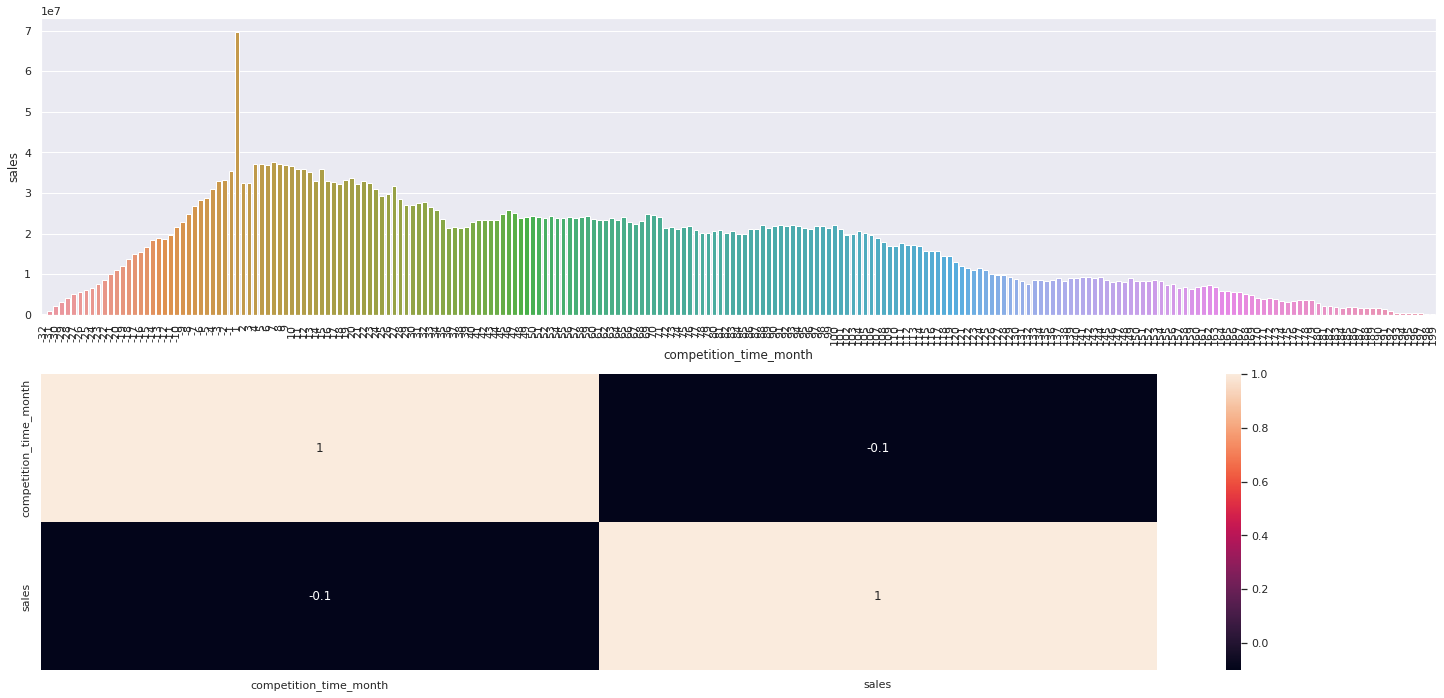

In [36]:
plt.subplot(2, 1, 1)
aux1 = df5[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 200) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90)

plt.subplot(2,1,2)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H4.** Stores with competitors more than 10KM away should have higher sales averages.

#### FALSE: As seen in hypothesis H2, stores that have a greater number of sales and consequently a greater average of sales are up to 4 km away.

### **H5.** Stores with longer promotions should sell more.

#### FALSE: Stores with longer active promotions sell less after a certain period of promotion.

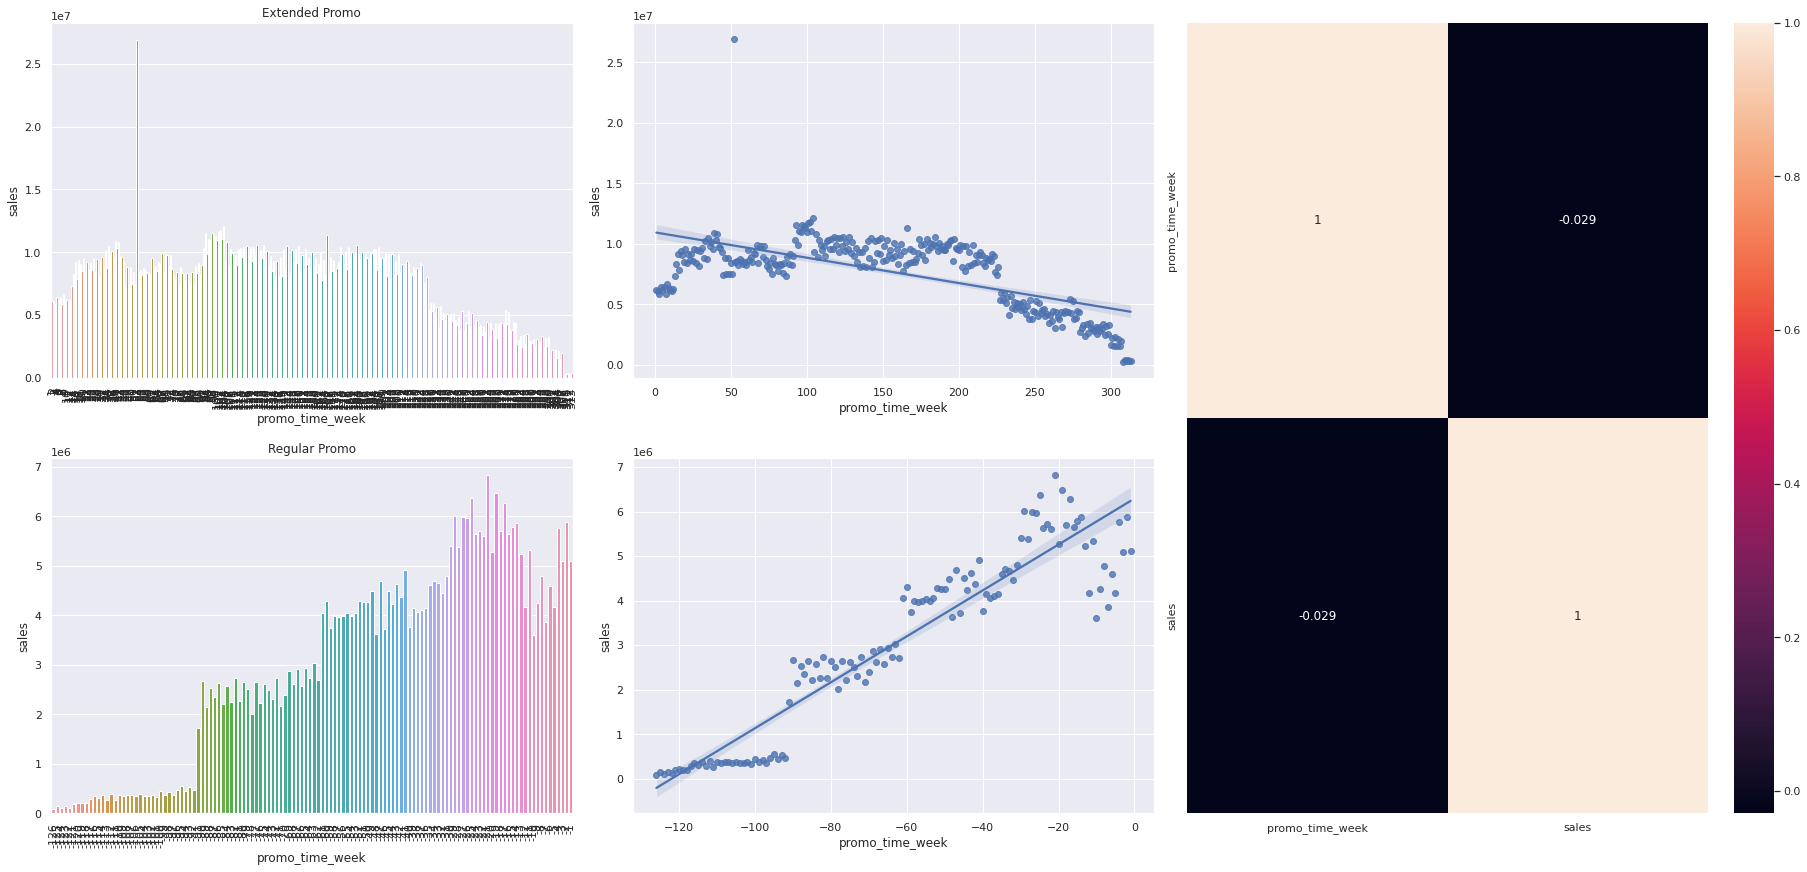

In [37]:
aux1 = df5[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

aux2 = aux1[aux1['promo_time_week'] > 0] #promo extend
aux3 = aux1[aux1['promo_time_week'] < 0 ] #promo regular


fig = plt.figure(constrained_layout=True)
specs = GridSpec(2, 3, figure=fig)


ax1 = fig.add_subplot(specs[0, 0])
sns.barplot(x='promo_time_week', y='sales', ax=ax1, data=aux2)
plt.title('Extended Promo')
plt.xticks(rotation=90)

ax2 = fig.add_subplot(specs[0, 1])
sns.regplot(x='promo_time_week', y='sales', ax=ax2, data=aux2)

ax3 = fig.add_subplot(specs[0:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True, ax=ax3)


ax4 = fig.add_subplot(specs[1, 0])
sns.barplot(x='promo_time_week', y='sales', ax=ax4, data=aux3)
plt.title('Regular Promo')
plt.xticks(rotation=90)

ax5 = fig.add_subplot(specs[1, 1])
sns.regplot(x='promo_time_week', y='sales', data=aux3, ax=ax5);
 


## <s>**H6.** Stores with more days of promotion should sell more.</s>

It will be seen in the next validation cycle as it is very similar to hypothesis H5.

### **H7.** Stores with more consecutive promotions should sell more.

#### FALSE: Stores with more consecutuve promotions sell less.

In [38]:
df5[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


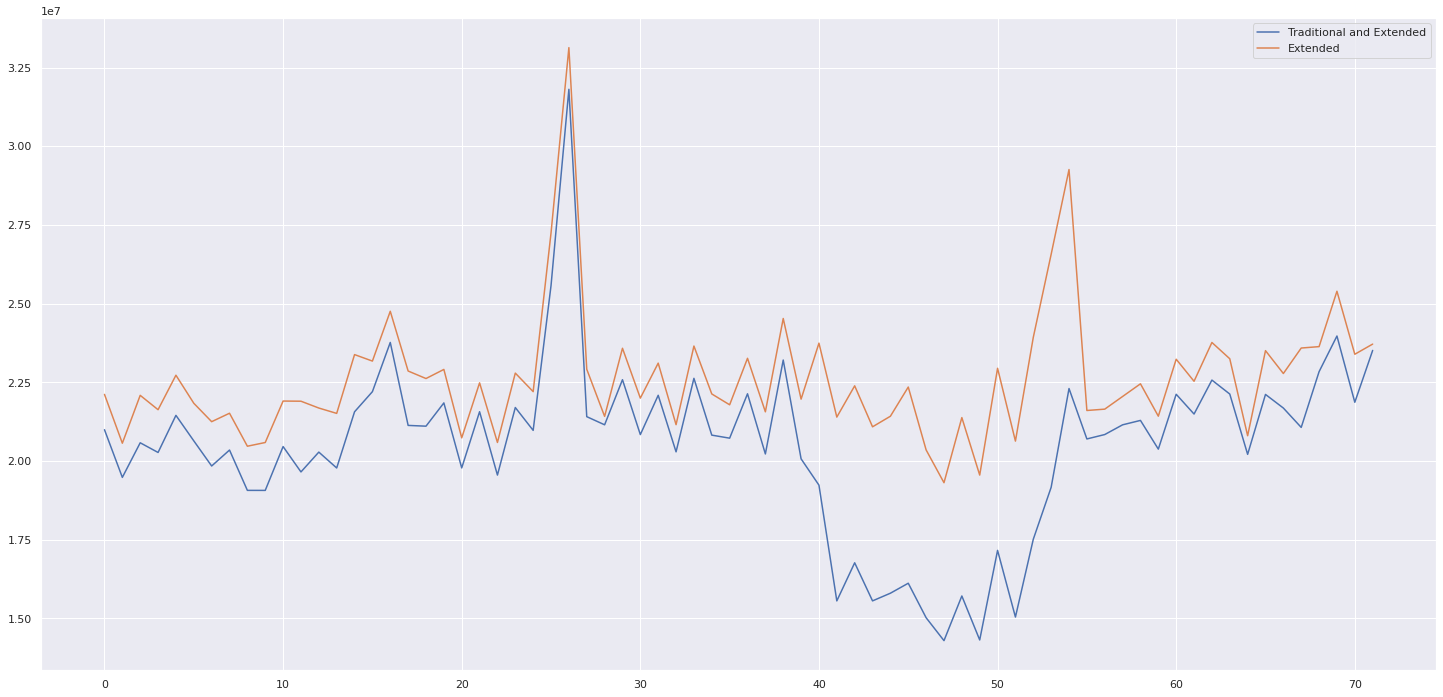

In [39]:
aux1 = df5[(df5['promo'] == 1) & (df5['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df5[(df5['promo'] == 1) & (df5['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax = ax)

ax.legend(labels=['Traditional and Extended', 'Extended'])

### **H8.** Stores open during the Christmas holiday should sell more.

#### FALSE: The Christmas holiday always sells less than the others.

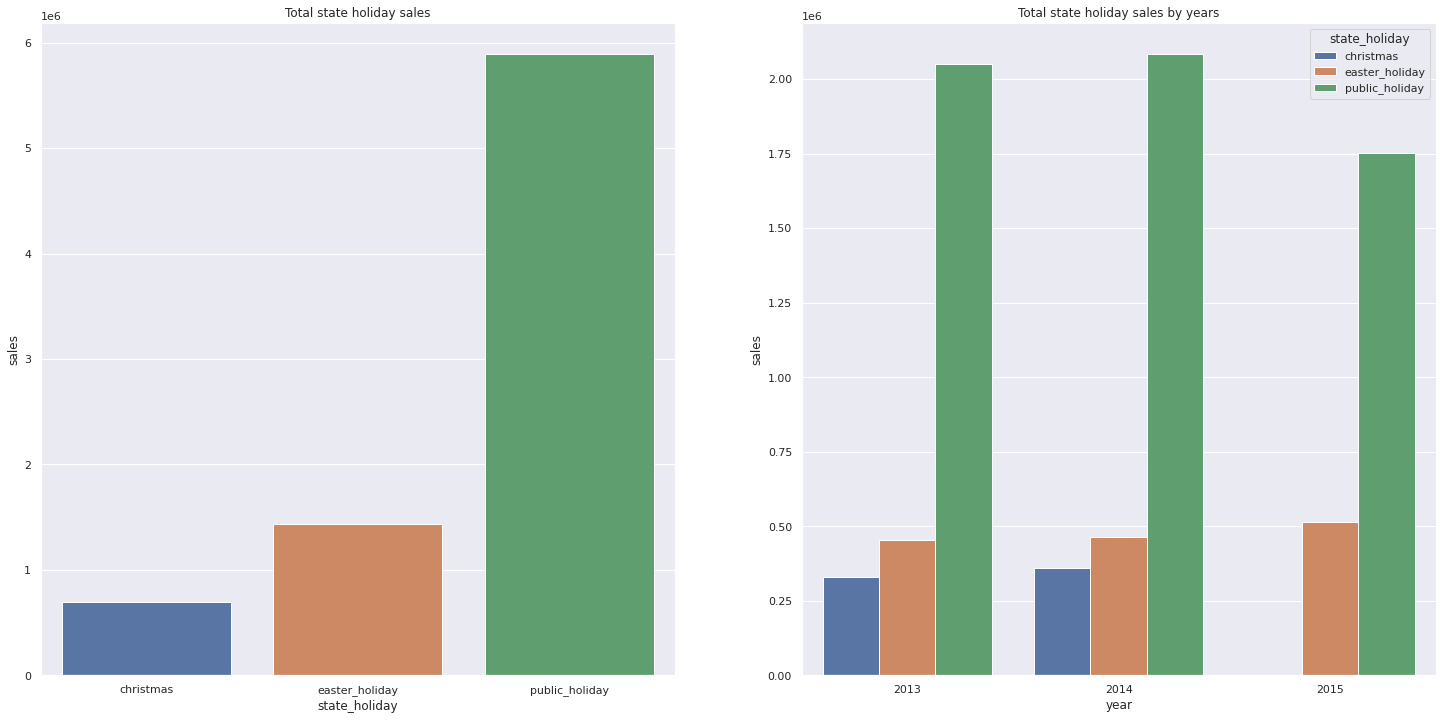

In [40]:
aux = df5[df5['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1)
plt.title('Total state holiday sales');

plt.subplot(1, 2, 2)
aux2 = aux[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)
plt.title('Total state holiday sales by years');


### **H9.** Stores should sell more over the years.

#### FALSE: The stores had a downward trend in the two years with closed periods (2013 and 2014). 
**Note**: 2015 does not have a closed period, only data until the end of July. But analyzing these periods in each year, the trend so far is that 2015 exceeds or equals the previous years, possibly breaking the downward trend.

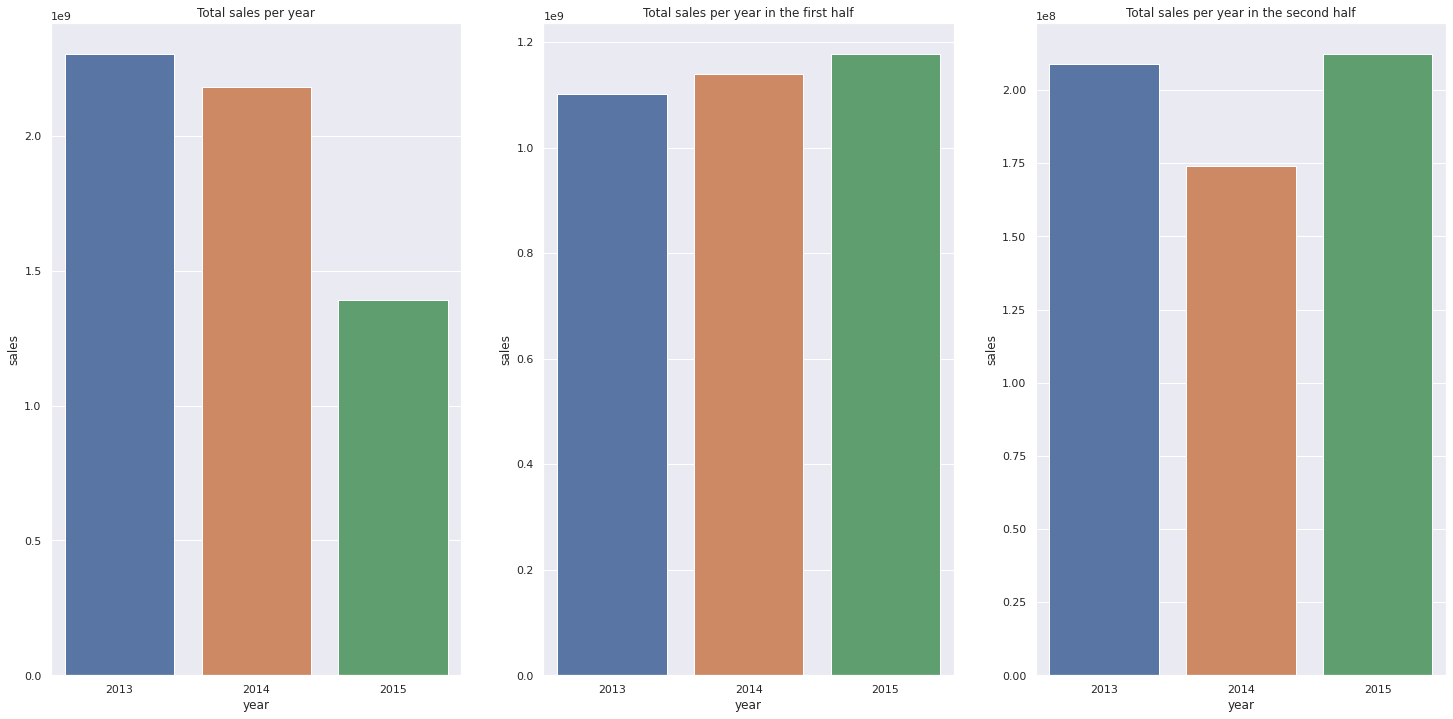

In [52]:
aux1 = df5[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1)
plt.title('Total sales per year');

plt.subplot(1,3,2)
aux2 = df5[['year', 'sales']][df5['month'] <= 6].groupby(['year']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2)
plt.title('Total sales per year in the first half');

plt.subplot(1,3,3)
aux2 = df5[['year', 'sales']][df5['month'] == 7].groupby(['year']).sum().reset_index()
sns.barplot(x='year', y='sales', data=aux2)
plt.title('Total sales per year in the july'); #july is last month with data in 2015

### **H10.** Stores should sell more in the second half of the year.

#### FALSE: Stores sell less in the second half of the year

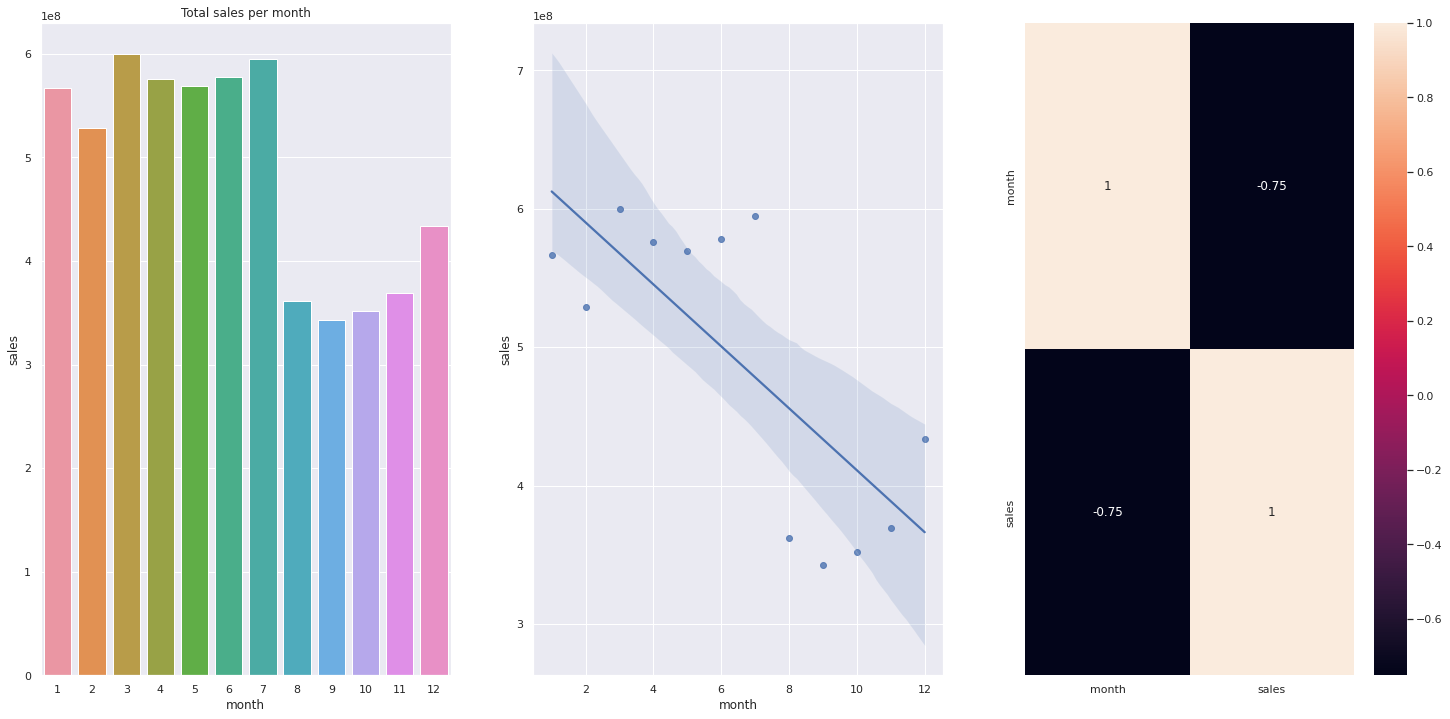

In [56]:
aux1 = df5[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1)
plt.title('Total sales per month');


plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### **H11.** Stores should sell more after the 10th of each month.

#### FALSE: Stores sell less in the first 10 days compared to the remaining days

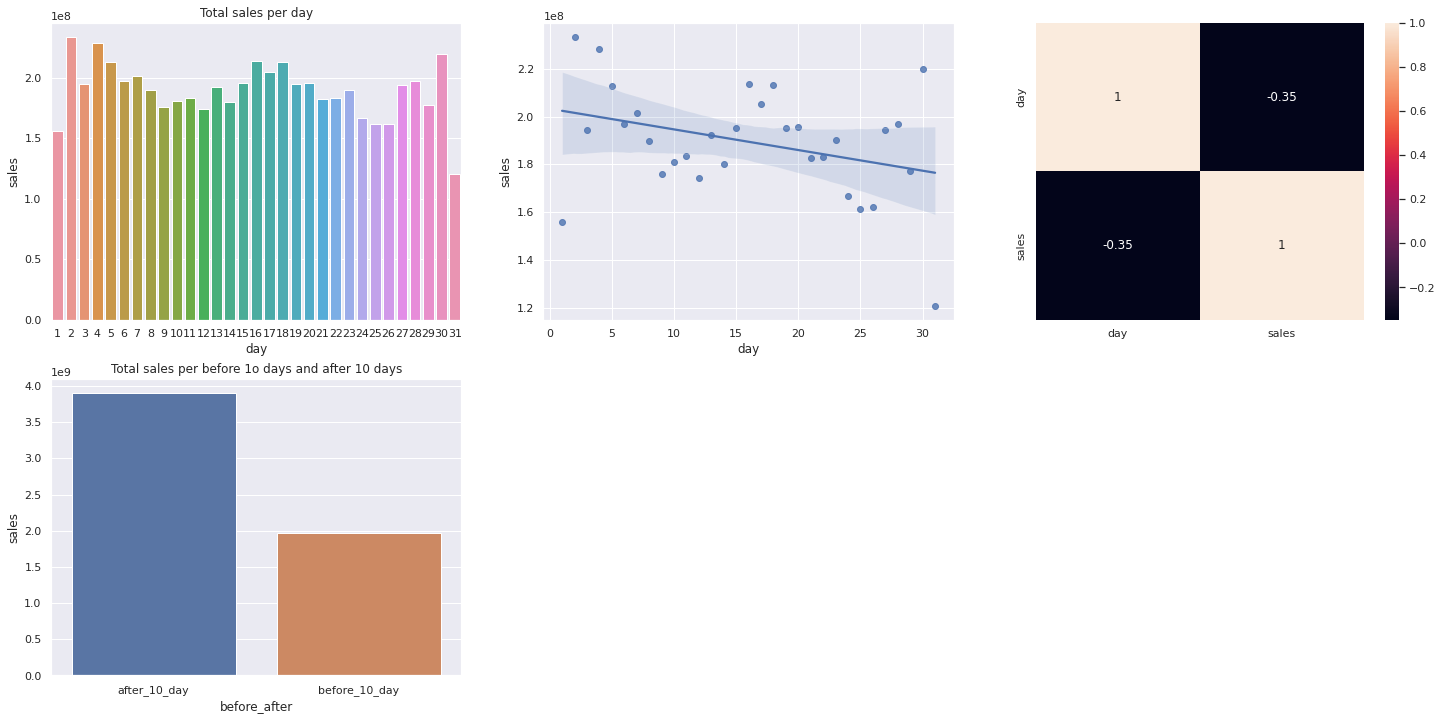

In [63]:
aux1 = df5[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,3,1)
sns.barplot(x='day', y='sales', data=aux1)
plt.title('Total sales per day');


plt.subplot(2,3,2)
sns.regplot(x='day', y='sales', data=aux1)

plt.subplot(2,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_day' if x <= 10 else 'after_10_day')

aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,3,4)
sns.barplot(x='before_after', y='sales', data=aux2)
plt.title('Total sales per before 1o days and after 10 days');


## **H12.** Stores should sell less on weekends.

## **H13.** Stores should sell less during school holidays.

## **H14.** Stores sell less in summer.

## 5.3. Multivariate analysis